In [1]:
import fenics as fn
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
#
from time import time

Given the following PDE:
$$-(a(x)u'(x))' = f(x), \quad x \in (0,1)$$
$$u(0) = u(1) = 0,$$
we want to recover $a(x)$ from observation $\{x_1,x_2,\dots,x_{N_s}\}\times\{u_1,u_2,\dots,u_{N_s}\}\subset \mathbb{R}^2$, by approximating $a$ with a quadratic polynomial $a_{nn}$.

In [2]:
import sys
print('Python version:',sys.version)

Python version: 3.8.13 (default, Oct 21 2022, 23:50:54) 
[GCC 11.2.0]


In [3]:
np.__version__

'1.21.5'

In [4]:
import scipy
scipy.__version__

'1.7.3'

In [5]:
# training set length
Ns = 11
# Number of neurons for hidden layer
Nn = 5

**Data generation**

In [6]:
a_unknown = fn.Expression('3.*pow(x[0],2) + x[0] + 1.',degree=2)

**FE setting**

In [7]:
Ne = 64
#
mesh = fn.IntervalMesh(Ne, 0,1)
#
Uh = fn.FunctionSpace(mesh,'CG',1)
#
u0 = 0.0
# RHS
f = fn.Expression('pi*sin(pi*x[0])',degree=2)
#
bc = fn.DirichletBC(Uh,u0,'on_boundary')
#
wh, vh = fn.TrialFunction(Uh), fn.TestFunction(Uh)
#
bilinear_form = a_unknown*fn.dot(fn.grad(wh),fn.grad(vh))*(fn.dx)
linear_rhs = f*vh*(fn.dx)
#
uh_sol = fn.Function(Uh)
fn.solve(bilinear_form == linear_rhs, uh_sol, bc)

Solving linear variational problem.


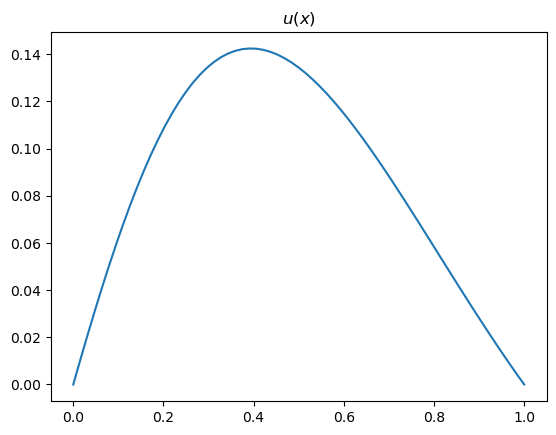

In [8]:
fn.plot(uh_sol)
plt.title(r'$u(x)$')
plt.show()

**Training set generation**

In [9]:
x_train = np.linspace(0,1,Ns)
print(x_train)
#
y_train = np.zeros(x_train.shape)
for i in range(x_train.shape[0]):
    y_train[i] = uh_sol(x_train[i])

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


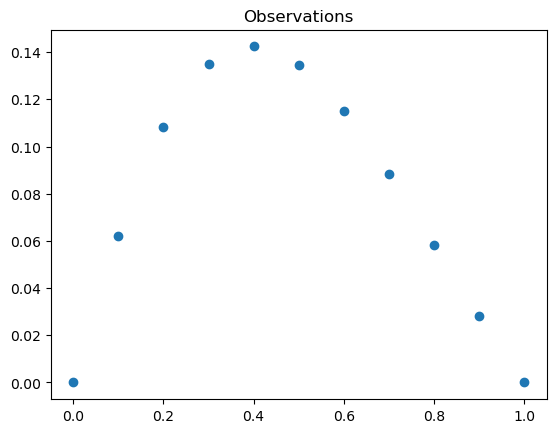

In [10]:
plt.plot(x_train,y_train,'o')
plt.title('Observations')
plt.show()

**Polynomial definition (FEniCS compatible)**

In [11]:
#a_nn FEniCS-compatible expression
a_nn = fn.Expression('a1*pow(x[0],2) + a2*x[0] + a3',a1=1.,a2=1.,a3=0.,degree=2)

**Loss function**

In [12]:
def cost_func(theta,alpha=0.0):
    # weight's update
    a_nn.a1 = theta[0]
    a_nn.a2 = theta[1]
    a_nn.a3 = theta[2]
    # Variational formulation
    bilinear_form_nn = a_nn*fn.dot(fn.grad(wh),fn.grad(vh))*(fn.dx)
    linear_rhs_nn = f*(vh)*(fn.dx)
    # computing FE solution
    uh_sol_nn = fn.Function(Uh)
    fn.solve(bilinear_form_nn == linear_rhs_nn, uh_sol_nn, bc)
    # observation from FE system with a_nn
    y_pred = np.zeros(x_train.shape)
    for i in range(x_train.shape[0]):
        y_pred[i] = uh_sol_nn(x_train[i])
    # loss evatuation
    cost = ((y_pred - y_train)**2).mean()
    return cost

**Training procedure**

In [13]:
np.random.seed(42)
theta = np.random.uniform(-1,1,3)  

In [14]:
# disable "Solving linear variational problem" message
fn.set_log_level(30)

In [15]:
start_time = time()
# Scipy non-gradient minimizer
argmin_th = minimize(cost_func, theta, args=(0.0), method='Nelder-Mead',
                      options={'xatol':1e-7,'fatol':1e-7,'maxiter': 500, 'disp':True})
#
print('Cost function',argmin_th.fun)
print('Computing time:',(time() - start_time)/60,'minutes')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 165
         Function evaluations: 306
Cost function 3.665003812506661e-21
Computing time: 0.007856233914693197 minutes


**Results**

In [16]:
theta_opt = argmin_th.x
a_nn_opt = a_nn

In [17]:
x_test = np.linspace(0,1,100)
a_pred  = np.zeros(x_test.shape)
a_exact = np.zeros(x_test.shape)
for i in range(x_test.shape[0]):
    a_pred[i]  = a_nn_opt(x_test[i])
    a_exact[i] = a_unknown(x_test[i])

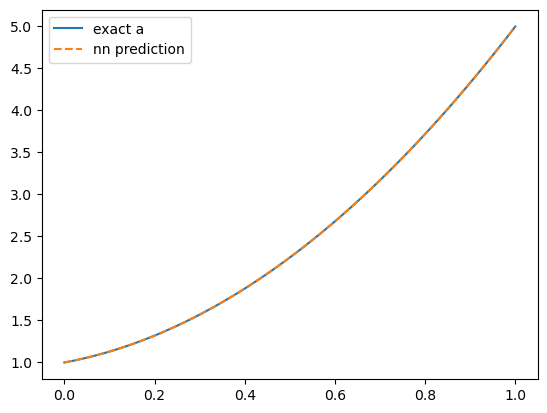

In [18]:
plt.plot(x_test,a_exact,label='exact a')
plt.plot(x_test,a_pred,
         label='nn prediction',
         linestyle='--')
plt.legend()